In [1]:
import numpy as np
import pandas as pd
import os
import random
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from numpy import array

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# fix random seed for reproducibility
tf.random.set_seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
df = pd.read_csv("/content/gdrive/My Drive/colab/dataframe_11g_5m.csv")
df.time = pd.to_datetime(df.time, dayfirst = True)
time = df['time'].values

df['time'] = pd.to_datetime(df.time , format = '%d/%m/%Y %H.%M.%S')
df.set_index('time',inplace=True)
points_per_day = 288 

df.count()

temperature    3168
humidity       3168
pressure       3168
people         3168
dtype: int64

In [4]:
features_considered = ['people']
uni_data = df[features_considered]
uni_data.index = df.index
uni_data.head()

,people
time,
2020-07-07 13:30:00+00:00,0.0
2020-07-07 13:35:00+00:00,0.0
2020-07-07 13:40:00+00:00,0.0
2020-07-07 13:45:00+00:00,0.0
2020-07-07 13:50:00+00:00,0.0


In [5]:
TRAIN_SPLIT = int(len(df)-3.5*points_per_day)

dataset = uni_data.values
# data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
# data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# dataset = (dataset-data_mean)/data_std

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  print(range(start_index, end_index))
  print(start_index - end_index)

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [7]:
past_history = 288
future_target = 2*12 # 24 points per h so 2 hours prediction
STEP = 3
x_train_multi, y_train_multi = multivariate_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

range(288, 2160)
-1872
range(2448, 3144)
-696


In [8]:
print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(1872, 96, 1)
(1872, 24, 1)
(696, 96, 1)
(696, 24, 1)


In [9]:
BATCH_SIZE = 10
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

to_be_predicted = tf.data.Dataset.from_tensor_slices(x_val_multi).batch(1)

In [10]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, #activation='sigmoid',
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
                                          
multi_step_model.add(tf.keras.layers.LSTM(16))#, activation='sigmoid'))

multi_step_model.add(tf.keras.layers.Dense(24, activation='sigmoid'))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='binary_crossentropy')

In [11]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(10, 24)


In [12]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 14s 72ms/step - loss: 0.5965 - val_loss: 0.4879
Epoch 2/10
200/200 [==============================] - 14s 68ms/step - loss: 0.5066 - val_loss: 0.4553
Epoch 3/10
200/200 [==============================] - 14s 69ms/step - loss: 0.4440 - val_loss: 0.5017
Epoch 4/10
200/200 [==============================] - 14s 69ms/step - loss: 0.4835 - val_loss: 0.4028
Epoch 5/10
200/200 [==============================] - 14s 70ms/step - loss: 0.4141 - val_loss: 0.4685
Epoch 6/10
200/200 [==============================] - 14s 70ms/step - loss: 0.3912 - val_loss: 0.3733
Epoch 7/10
200/200 [==============================] - 14s 70ms/step - loss: 0.3973 - val_loss: 0.4234
Epoch 8/10
200/200 [==============================] - 14s 71ms/step - loss: 0.3910 - val_loss: 0.4695
Epoch 9/10
200/200 [==============================] - 14s 72ms/step - loss: 0.3709 - val_loss: 0.4054
Epoch 10/10
200/200 [==============================] - 15s 76ms/step - loss: 0.370

In [13]:
def multi_step_plot(history, true_future, prediction):
  
  plt.figure(figsize=(10, 5))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 0]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')

  if prediction.any():
     plt.plot(np.arange(num_out)/STEP, np.round(np.array(prediction)), 'ro',
              label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

def create_time_steps(length):
  return list(range(-length, 0))

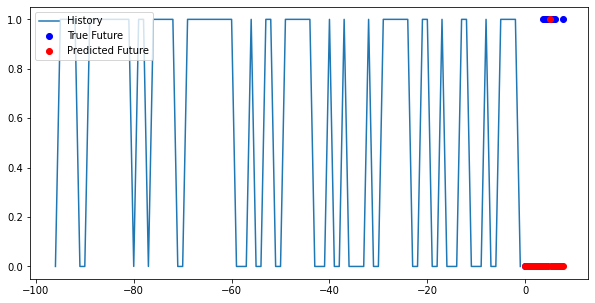

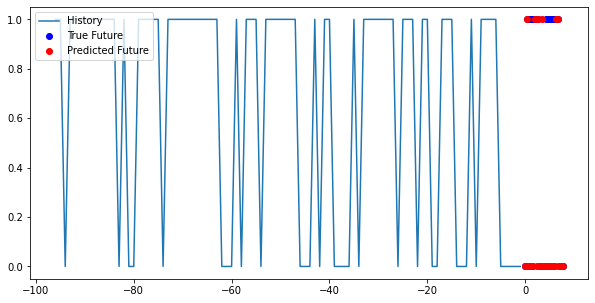

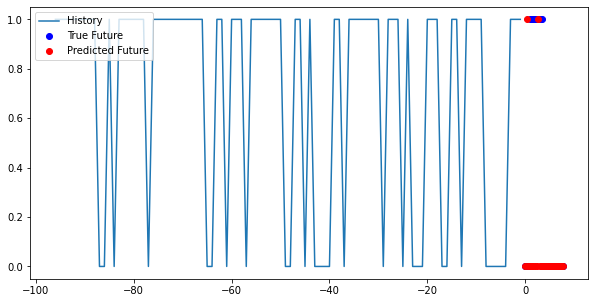

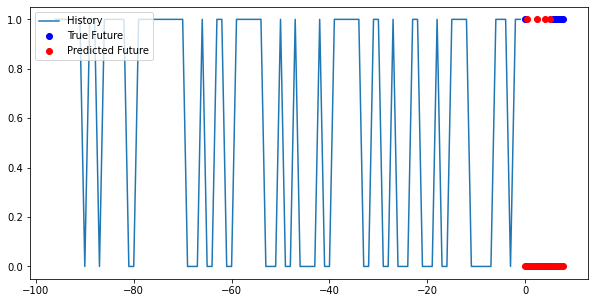

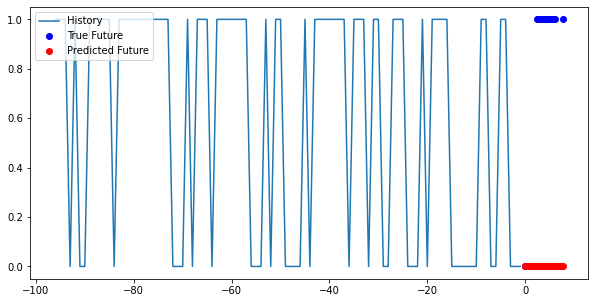

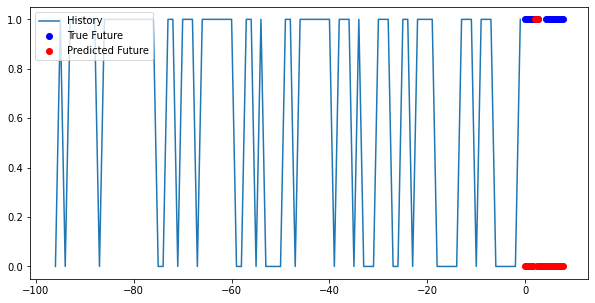

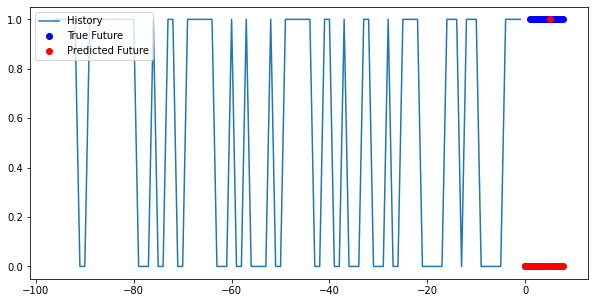

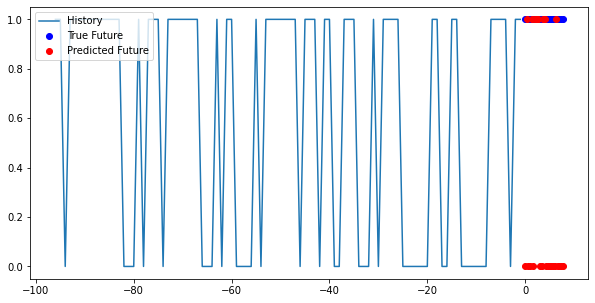

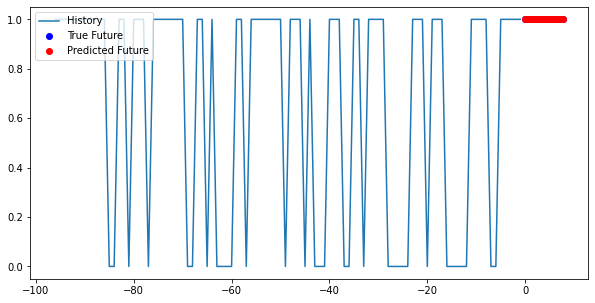

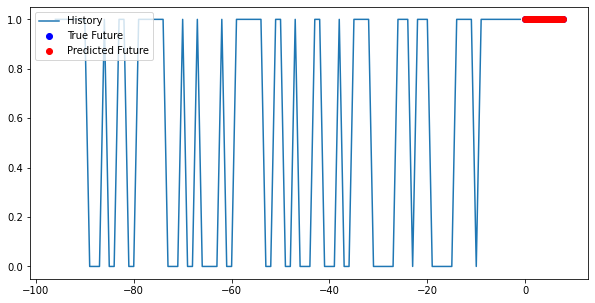

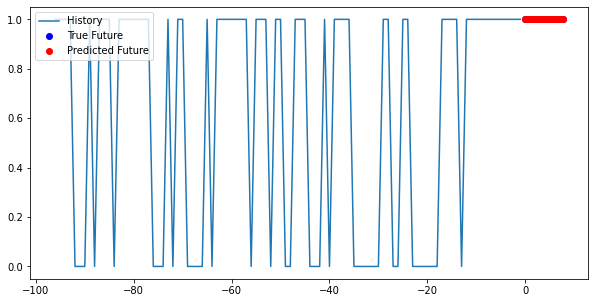

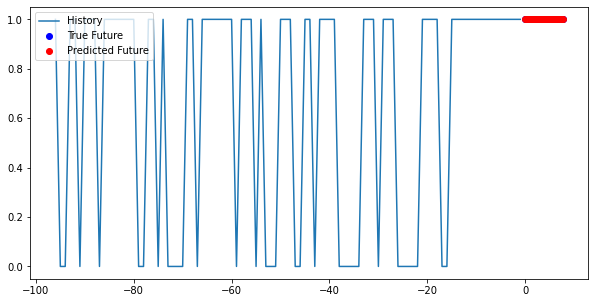

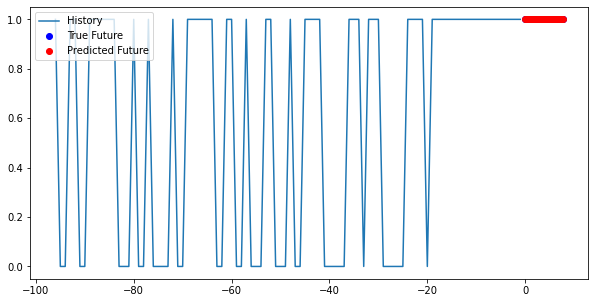

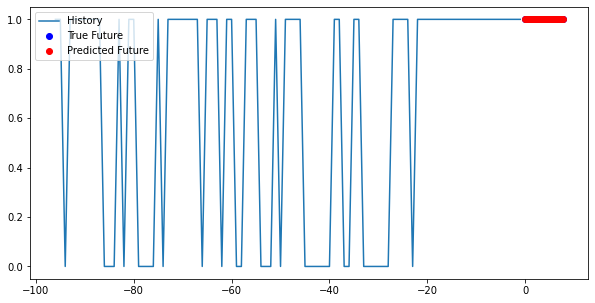

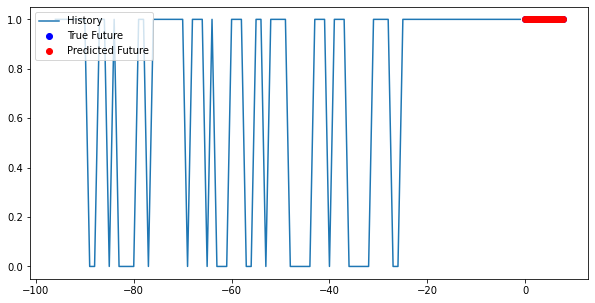

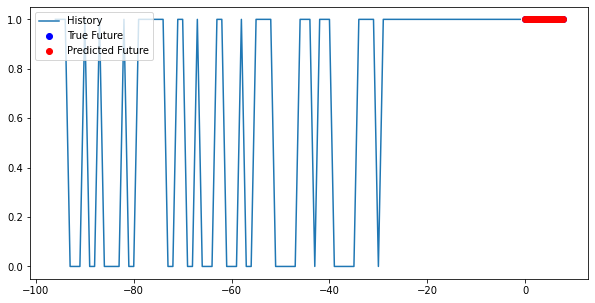

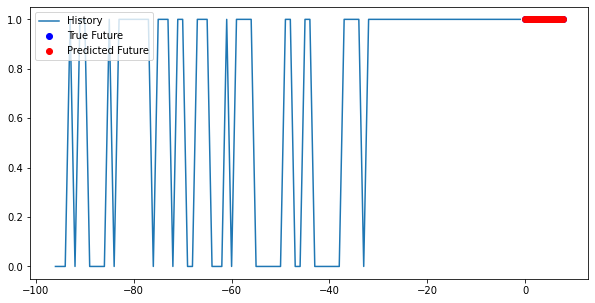

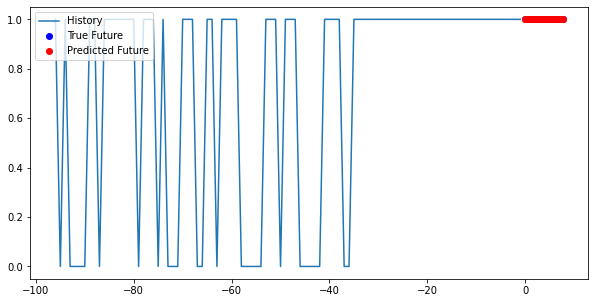

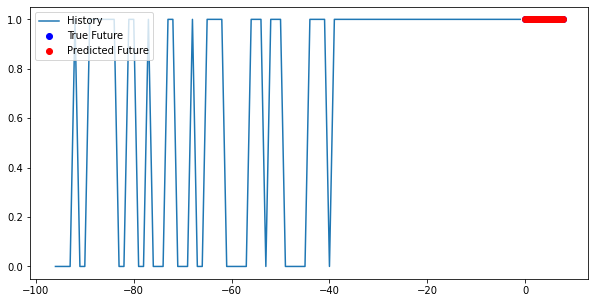

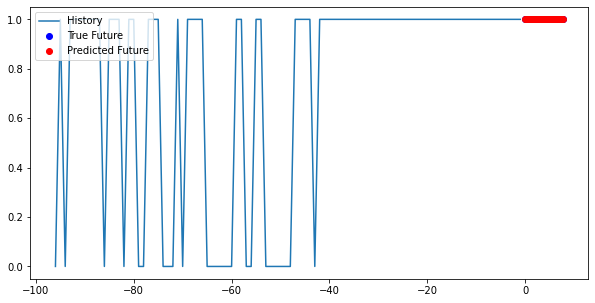

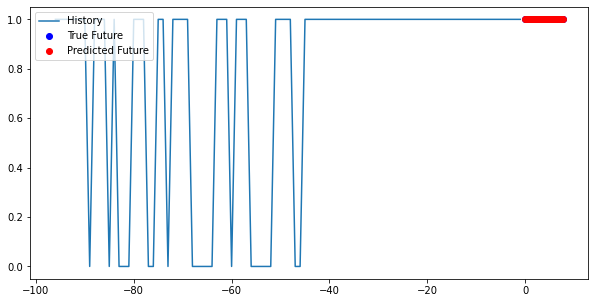

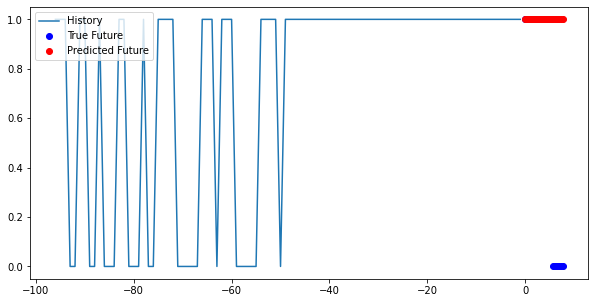

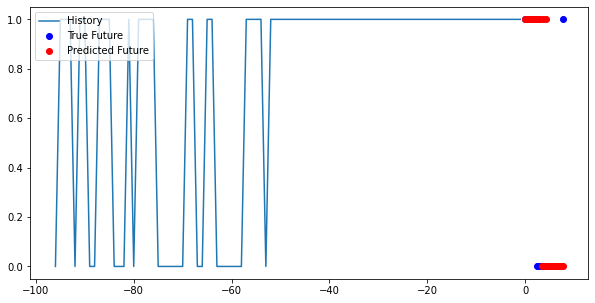

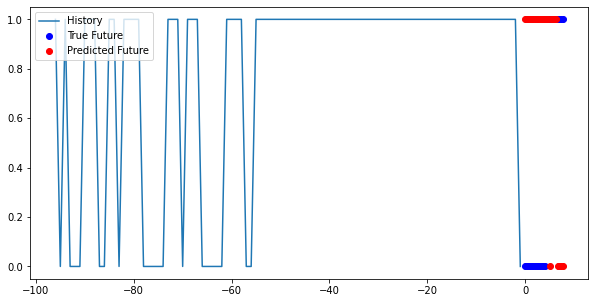

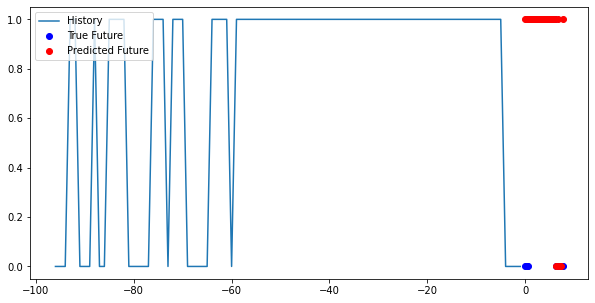

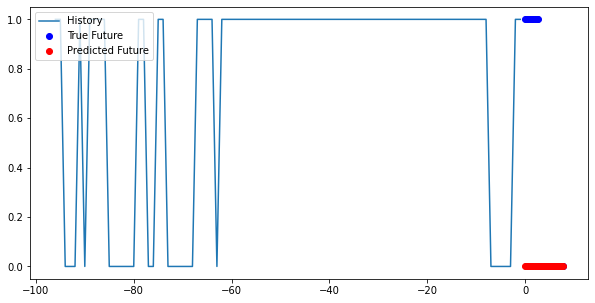

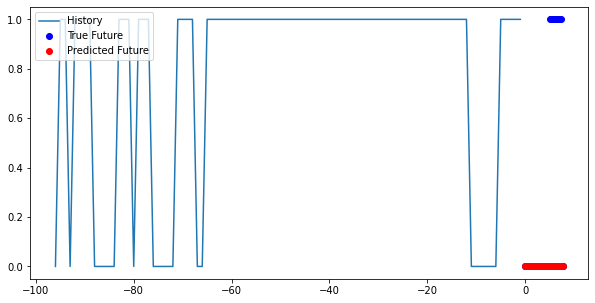

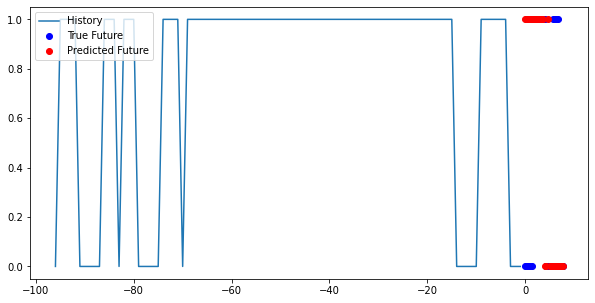

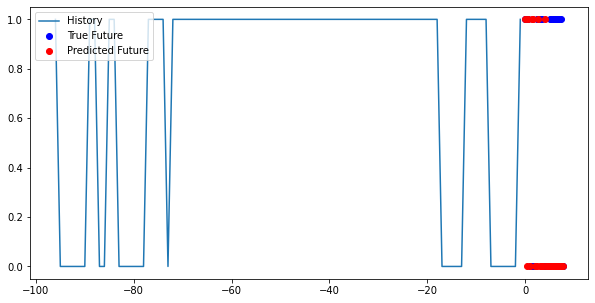

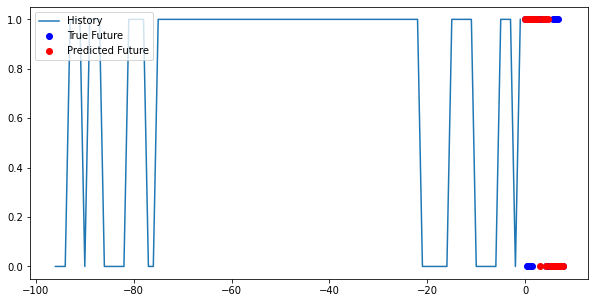

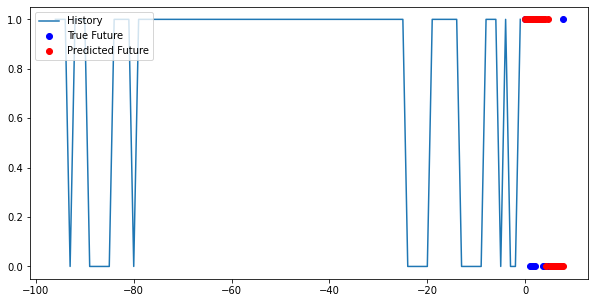

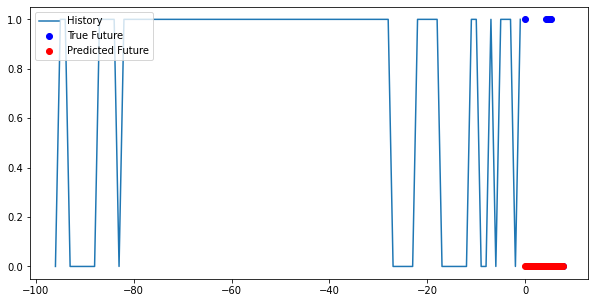

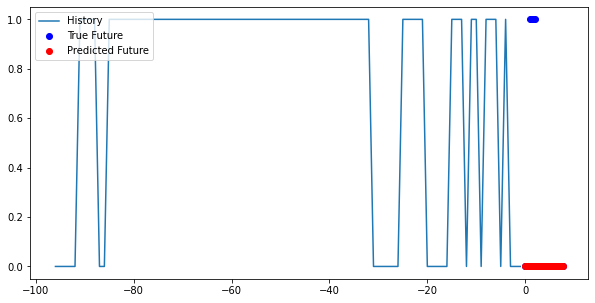

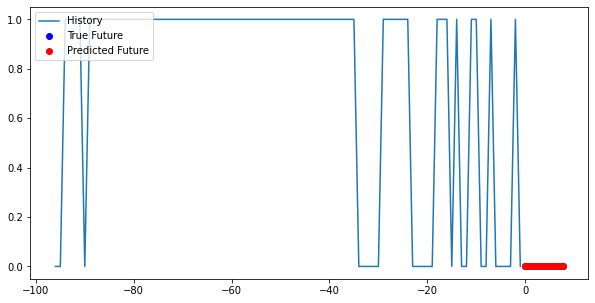

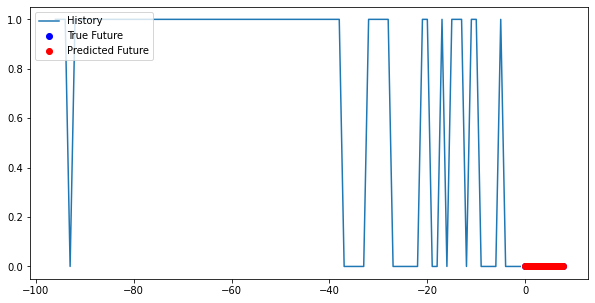

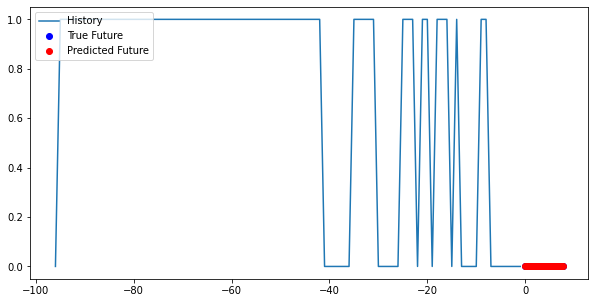

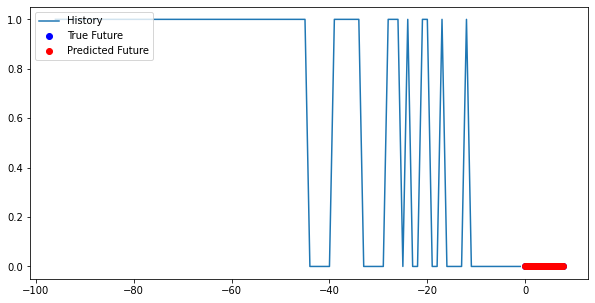

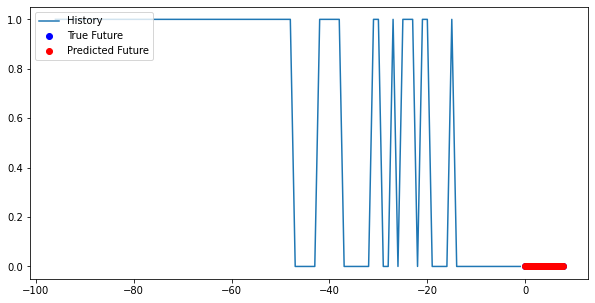

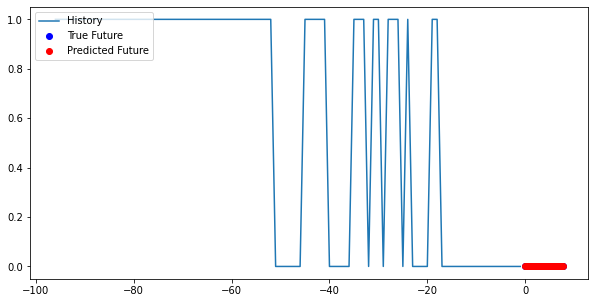

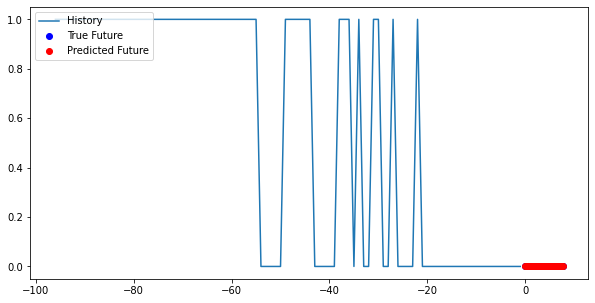

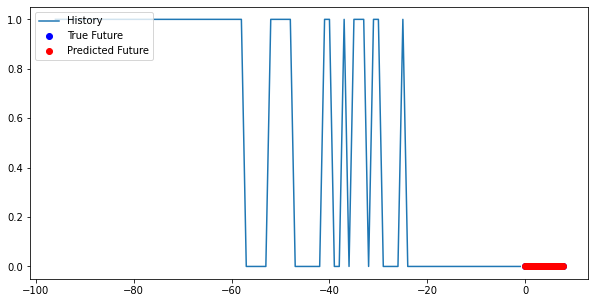

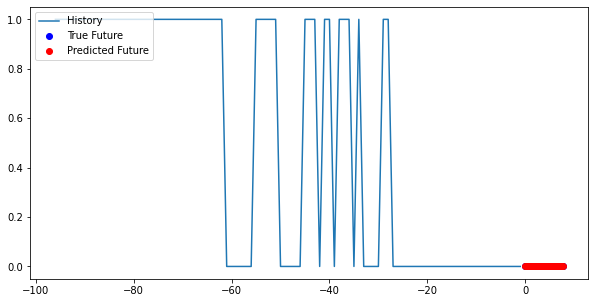

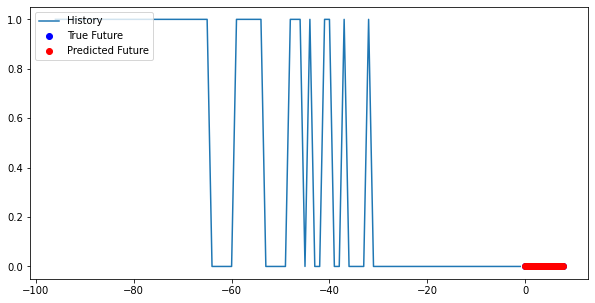

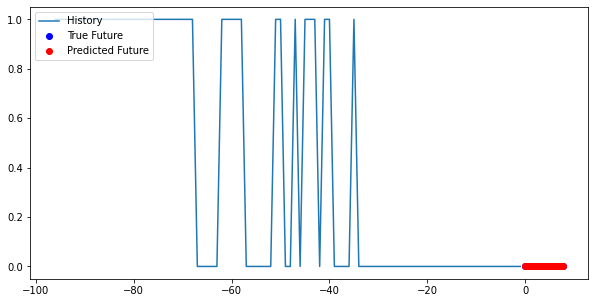

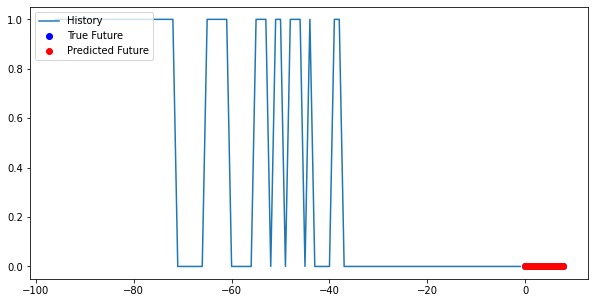

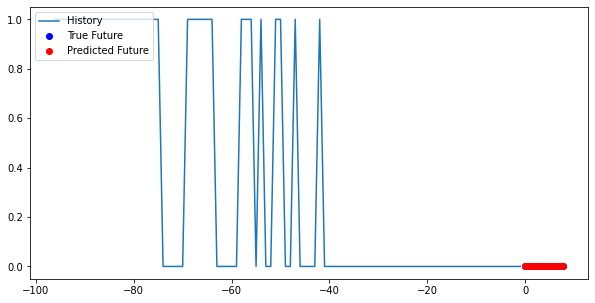

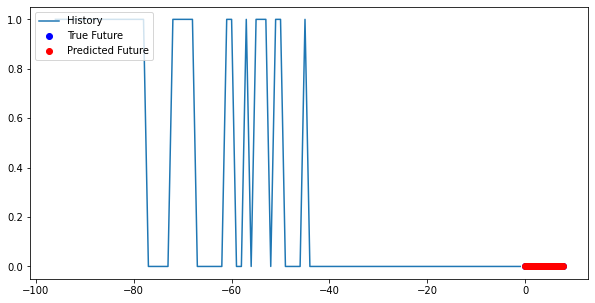

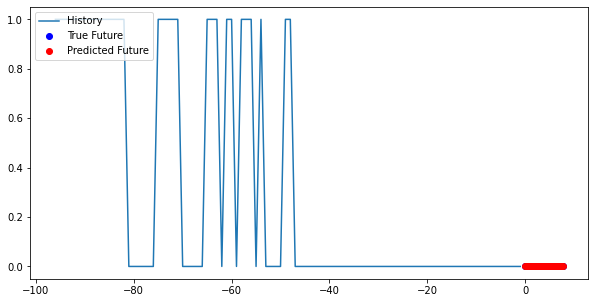

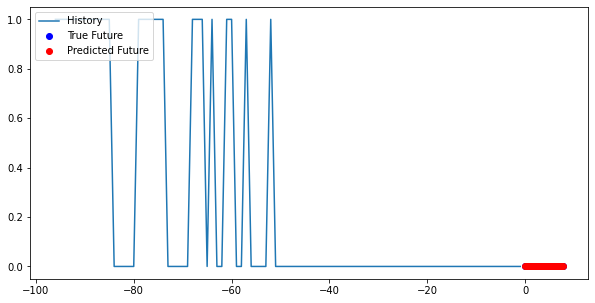

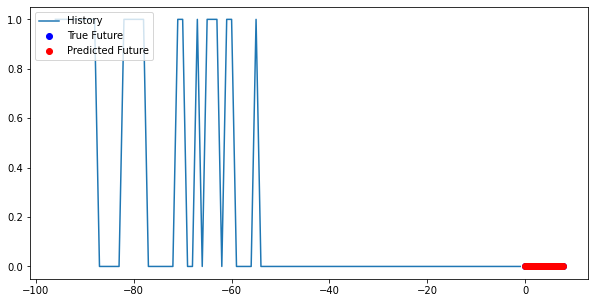

In [14]:
for x, y in val_data_multi.take(50):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [15]:
#multi_step_model.save('/content/gdrive/My Drive/colab/perople_model.h5')

In [16]:
score = multi_step_model.evaluate(x_val_multi, y_val_multi, batch_size=BATCH_SIZE, verbose=0)
score

0.43435853719711304